In [2]:
%matplotlib inline
import random
import torch

# 造数据，用的是正态分布，并加入了正态分布的噪音
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    # print(X.shape)
    Y = torch.matmul(X, w) + b
    Y += torch.normal(0, 0.01, Y.shape)
    return X, Y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)



features: tensor([0.7314, 1.3632]) label: tensor([1.0234])


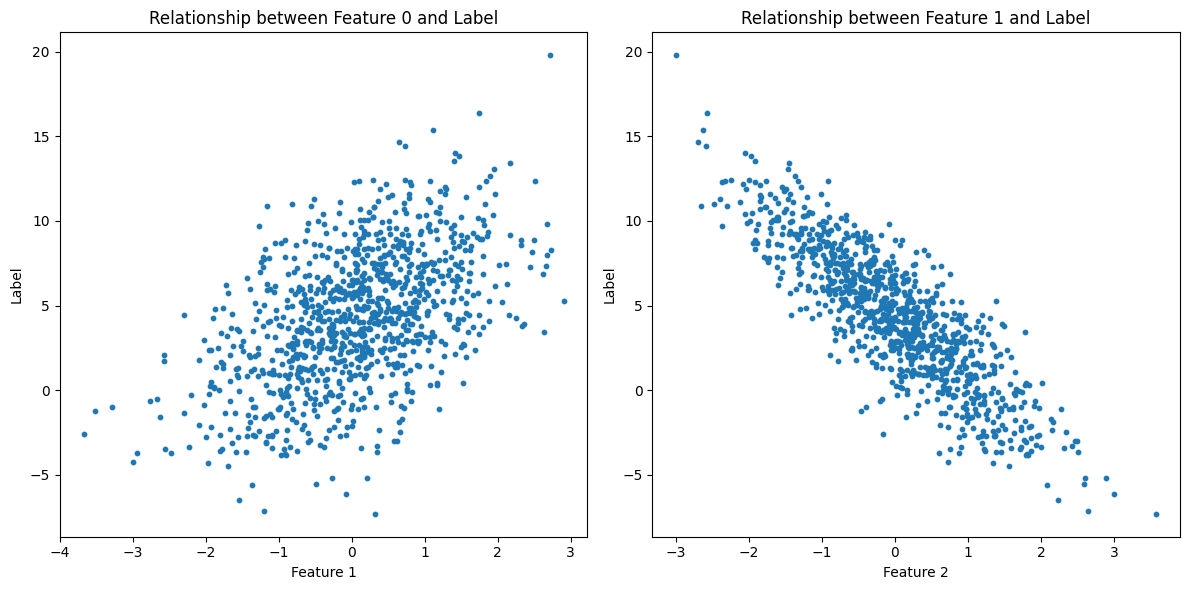

In [3]:
# 显示打印数据
print('features:', features[0], 'label:', labels[0])
import matplotlib.pyplot as plt
# 设置图形的大小
# 设置整个图像窗口的大小
plt.figure(figsize=(12, 6))  # 宽度12英寸，高度6英寸

# 绘制第一个特征与标签的关系
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.scatter(features[:, 0].numpy(), labels.numpy(), s=10)  # s 是点的大小
plt.title("Relationship between Feature 0 and Label")
plt.xlabel("Feature 1")
plt.ylabel("Label")

# 绘制第二个特征与标签的关系
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.scatter(features[:, 1].numpy(), labels.numpy(), s=10)  # s 是点的大小
plt.title("Relationship between Feature 1 and Label")
plt.xlabel("Feature 2")
plt.ylabel("Label")

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [4]:
# 梯度下降算法
# 看到https://www.bilibili.com/video/BV1wM4m117mp/?spm_id_from=333.788.videopod.episodes&vd_source=7bfd3d802539ef38a36d06f240a9b7ca&p=21     4：17
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些索引是随机洗牌的，这有助于训练
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        # 这里只针对
        # yield 是一个关键字，用来定义生成器函数。生成器函数不是一次性返回所有结果，
        #   而是每次“生成”一个值，并在下一次迭代时从上次暂停的地方继续执行。

        # batch_indices是一个tensor类型数据
        # print(features[batch_indices].shape)
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, Y in data_iter(batch_size, features, labels):
    # print(X, '\n', Y)
    break


In [5]:
# 梯度下降

# 定义初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X,w,b):
    return X @ w + b

def squared_loss(y_hat, y):
    """"均方误差"""
    # print(((y_hat - y.reshape(y_hat.shape)) ** 2/ 2))
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            # 这里的/ batch_size其实是一个标量，让learning rate不随着batch size的变化而变化
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 开始迭代
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # 'X' 和 'y' 的小批量损失
        # 因为 'l' 是一个向量，'batch_size' 个 1 项的和，而不是一个标量。所以 'l' 中的所有项求和
        # 为什么需要 sum()？因为 backward() 是 PyTorch 用于计算梯度的操作，但它要求输入是一个标量（scalar）。
        # 且这里算出来的梯度是每个w分量对于每个样本梯度的累加
        l.sum().backward()  # 使 'w' 和 'b' 的梯度累积
        # 一次batch做一次梯度下降。
        sgd([w, b], lr, batch_size)  # 使用自定义的随机梯度下降更新参数

    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"{w = }")
        print(f"{b = }")
        # 所以这里也是同理，因为loss是一个样本量大小的向量，所以需要用mean表示
        print(f'epoch {epoch + 1}, loss {float(torch.mean(train_l))}')

# print(b)

w = tensor([[ 1.9454],
        [-3.2288]], requires_grad=True)
b = tensor([4.0068], requires_grad=True)
epoch 1, loss 0.034893203526735306
w = tensor([[ 1.9998],
        [-3.3919]], requires_grad=True)
b = tensor([4.1911], requires_grad=True)
epoch 2, loss 0.00012097135186195374
w = tensor([[ 2.0004],
        [-3.3998]], requires_grad=True)
b = tensor([4.1995], requires_grad=True)
epoch 3, loss 4.775896741193719e-05


In [6]:
# 线性回归的简洁实现：

# 数据和batch的操作
import torch.utils.data as data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train = True):
    dataset = data.TensorDataset(*data_arrays)
    # 它每次会随机挑选batch_size个样本出来，并可以控制是否打乱顺序
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size, True)
# 创建一个迭代器iter()
print(type(iter(data_iter)))
next(iter(data_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


[tensor([[ 0.6563, -1.4377],
         [-1.0284, -0.3903],
         [ 0.9963, -0.5915],
         [ 0.1429, -1.4264],
         [ 0.4953, -1.0106],
         [ 1.1295,  0.0181],
         [ 0.5828, -0.2954],
         [ 1.5274,  0.0112],
         [-1.1992,  0.6586],
         [-0.0148,  0.6218]]),
 tensor([[10.3923],
         [ 3.4661],
         [ 8.1966],
         [ 9.3254],
         [ 8.6381],
         [ 6.3947],
         [ 6.3742],
         [ 7.2099],
         [-0.4344],
         [ 2.0459]])]

In [7]:
from torch import nn
# 'nn' 是神经网络的缩写
from torch import nn

# 表示一个全连接层（Fully Connected Layer）
# 参数：
# in_features=2: 输入有 2 个特征
# out_features=1: 输出 1 个数
net = nn.Sequential(nn.Linear(2, 1))

# 初始化参数w和b
# 手动设置 net 中第一个层（也就是 nn.Linear(2, 1)）的权重和偏置的初始值。
# 使用 with torch.no_grad() 进行参数初始化
with torch.no_grad():
    # 将权重用均值为 0、标准差为 0.01 的正态分布初始化
    net[0].weight.normal_(0, 0.01)
    # 把偏置设置成 0
    net[0].bias.fill_(0)

loss = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)


# 训练模块
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        optimizer.zero_grad()
        l.backward()
        #这里的 optimizer 是之前定义的 torch.optim.SGD 优化器（使用随机梯度下降，学习率 lr=0.03），它会根据梯度下降公式更新参数，使损失减少。
        optimizer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000188
epoch 2, loss 0.000097
epoch 3, loss 0.000095
